### TODO

- [ ] Interpret model. Try to figure out which feature influence the AQI; is it just date or temperature/precipitation can come and play a role?


### Further improvements
- [ ] External data
- [ ] Different date feature engineering approach
- [ ] Remove/leave pollutant
- [x] Model ensembling
- [ ] LSTMs https://medium.com/@masterofchaos/lstms-made-easy-a-simple-practical-approach-to-time-series-prediction-using-pytorch-fastai-103dd4f27b82
- [x] Use random forests
- [ ] Weight decay to avoid overfitting
- [ ] Divide all columns by their max value to normalize (fastai should do it but unclear yet why I don't see that in the dataloaders batch)


Compare results with https://aqicn.org/city/montreal/

In [1]:
# Imports for JupyterLite
%pip install -q ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import os
from fastai.tabular.all import *
import matplotlib.pyplot as plt
import ipywidgets as widgets
import concurrent.futures
import urllib.request

# Adjust this based on data availibility
# FIRST_DAY = pd.Timestamp("2012-01-01")
FIRST_DAY = pd.Timestamp("2016-01-01")

# When the data analysis should stop
# The quality of predictions decline rapidly after Oct 2023 so let's zoom on that for now
LAST_DAY = pd.Timestamp("2024-05-10")

def filter_known_range(df):
  return df[(df['datetime'] >= FIRST_DAY) & (df['datetime'] < LAST_DAY)]

In [3]:
def get_csv(url, local_filename):
    if not os.path.exists(local_filename):
        print(f"{local_filename} not found locally. Downloading and reading from URL...")
        df = pd.read_csv(url)
        df.to_csv(local_filename, index=False)  # Save the downloaded file locally
    else:
        print(f"Reading {local_filename} from local storage...")
        df = pd.read_csv(local_filename)
    return df

In [8]:
# MONTREAL/PIERRE ELLIOTT TRUDEAU INTL QUEBEC
# This station has precipitation but doesn't have a categorical value of weather (e.g cloudy, rain, etc)
station_ids = ["30165", "51157"]

years = range(FIRST_DAY.year, LAST_DAY.year + 1)
months = range(1, 13)

dates = [(station_id, month, year) for year in years for month in months for station_id in station_ids]
urls = list(map(lambda xy: f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={xy[0]}&Year={xy[2]}&Month={xy[1]}&Day=1&timeframe=1&submit=Download+Data", dates))

def get_weather_csv(url):
    station_id = url.split('&stationID=')[1].split('&')[0]
    year = url.split('&Year=')[1].split('&')[0]
    month = url.split('&Month=')[1].split('&')[0]
    filepath = f"weather_{station_id}-{year}-{month}.csv"
    if os.path.exists(filepath):
        return filepath
    try:
        # Download and save the file
        with urllib.request.urlopen(url, timeout=30) as response, open(filepath, 'wb') as out_file:
            out_file.write(response.read())
        return filepath
    except Exception as e:
        print(f"Failed to download {url}: {str(e)}")
        return None

# Use a ThreadPoolExecutor to manage concurrent downloads
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    # Start the load operations and mark each future with its URL
    future_to_url = {executor.submit(get_weather_csv, url): url for url in urls}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            filepath = future.result()
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))


In [5]:
def plot_preds(df):
    dates = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='D')
    options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]

    date_range_slider = widgets.SelectionRangeSlider(
        options=options,
        index=(0, len(options)-1),
        description='Select Date Range',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    def update_plot(date_range):
        # Filter the DataFrame for the selected date range
        start_date, end_date = date_range
        mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
        filtered_df = df.loc[mask].set_index('datetime')

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(filtered_df['Actual'], label='Actual AQI', color='blue')
        plt.plot(filtered_df['Predicted'], label='Predicted AQI', color='red', alpha=0.6)
        plt.title('Comparison of Actual and Predicted AQI')
        plt.xlabel('Date')
        plt.ylabel('AQI Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Connect the SelectionRangeSlider to the update_plot function
    widgets.interact(update_plot, date_range=date_range_slider)

In [6]:
def split_data(df):
  split_date_valid = pd.Timestamp('2022-01-01')
  split_date_test = pd.Timestamp('2023-05-01')

  train_idx = df['datetime'] < split_date_valid
  valid_idx = (df['datetime'] >= split_date_valid) & (df['datetime'] < split_date_test)
  test_idx = df['datetime'] >= split_date_test

  train_idxs = np.where(train_idx)[0].tolist()
  valid_idxs = np.where(valid_idx)[0].tolist()
  test_idxs = np.where(test_idx)[0].tolist()

  return (train_idxs, valid_idxs, test_idxs)

In [7]:
def mk_analysis_df(df, preds, max):
  # Create DataFrame
  _df = pd.DataFrame({
      'datetime': df['datetime'],
      'Actual': df['valeur'] * max,
      'Predicted': preds.flatten() * max,
  })

  _df['Error'] = abs((_df['Actual'] - _df['Predicted']) / _df['Actual']) * 100


  return _df

def mk_dls(df):
  cont,cat = cont_cat_split(df, max_card=20, dep_var='valeur')
  return TabularPandas(
    df,
    procs=[Categorify, Normalize],
    cat_names=cat,
    cont_names=cont,
    y_names=['valeur'],
    splits=(train_idxs, valid_idxs),
    y_block=RegressionBlock()
).dataloaders(bs=2048)


# Weather data exploration

- [Glossary](https://climate.weather.gc.ca/glossary_e.html)

In [9]:
all_files = []
for filename in os.listdir("."):
  if filename.startswith("weather_"):
    all_files.append(pd.read_csv(filename))

weather_df = pd.concat(all_files)
weather_df.rename(columns={'Date/Time (LST)': 'datetime',
                           "Temp (°C)": "temp",
                           "Precip. Amount (mm)":
                           "precip", "Rel Hum (%)": "rel_humid",
                           "Weather": "weather",
                           "Wind Chill": "wind_chill",
                           "Stn Press (kPa)": "pressure",
                           "Visibility (km)": "visibility"}, inplace=True)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])


In [10]:
weather_station_df1 = weather_df[weather_df['Station Name'] == 'MONTREAL/PIERRE ELLIOTT TRUDEAU INTL'][['datetime', 'temp', 'precip', 'rel_humid']]
weather_station_df2 = weather_df[weather_df['Station Name'] == 'MONTREAL INTL A'][['datetime', 'weather', 'wind_chill', 'pressure', 'visibility']]

weather_df = pd.merge(weather_station_df1, weather_station_df2, on='datetime')
weather_df = filter_known_range(weather_df)

weather_df

,datetime,temp,precip,rel_humid,weather,wind_chill,pressure,visibility
0,2022-08-01 00:00:00,22.1,0.0,78.0,NaN,NaN,101.09,24.1
1,2022-08-01 01:00:00,22.1,0.0,73.0,Mostly Cloudy,NaN,101.05,24.1
2,2022-08-01 02:00:00,21.8,0.0,77.0,NaN,NaN,101.01,24.1
3,2022-08-01 03:00:00,21.7,0.0,76.0,NaN,NaN,100.98,24.1
4,2022-08-01 04:00:00,21.4,0.0,77.0,Mostly Cloudy,NaN,100.98,24.1
...,...,...,...,...,...,...,...,...
78907,2024-03-31 19:00:00,7.7,0.0,34.0,Clear,NaN,100.76,48.3
78908,2024-03-31 20:00:00,7.3,0.0,36.0,NaN,NaN,100.80,24.1
78909,2024-03-31 21:00:00,6.6,0.0,43.0,NaN,NaN,100.90,24.1
78910,2024-03-31 22:00:00,5.8,0.0,60.0,Mainly Clear,NaN,100.95,24.1


In [12]:
weather_df.fillna({"precip": 0,
                   "temp": weather_df['temp'].fillna(method='bfill'),
                   "rel_humid": weather_df['rel_humid'].mode()[0],
                   "wind_chill": weather_df['wind_chill'].fillna(method='bfill'),
                   "pressure": weather_df['pressure'].mode()[0],
                   "visibility": weather_df['visibility'].mode()[0],
                   "weather": weather_df['weather'].mode()[0]}, inplace=True)

weather_df.sort_values("datetime", inplace=True)

assert weather_df[weather_df.isna().any(axis=1)].empty == True

weather_df

,datetime,temp,precip,rel_humid,weather,wind_chill,pressure,visibility
13104,2016-01-01 00:00:00,-1.3,0.0,80.0,Mostly Cloudy,-7.0,100.92,24.1
13105,2016-01-01 01:00:00,-1.2,0.0,79.0,Mostly Cloudy,-8.0,100.92,24.1
13106,2016-01-01 02:00:00,-1.5,0.0,78.0,Mostly Cloudy,-7.0,100.91,24.1
13107,2016-01-01 03:00:00,-1.7,0.0,78.0,Snow,-7.0,100.93,24.1
13108,2016-01-01 04:00:00,-2.5,0.0,84.0,Snow,-8.0,100.88,9.7
...,...,...,...,...,...,...,...,...
64411,2024-05-09 19:00:00,12.4,0.0,65.0,Mostly Cloudy,-6.0,100.67,24.1
64412,2024-05-09 20:00:00,10.9,0.0,71.0,Mostly Cloudy,-6.0,100.71,24.1
64413,2024-05-09 21:00:00,10.7,0.0,71.0,Mostly Cloudy,-6.0,100.71,24.1
64414,2024-05-09 22:00:00,9.9,0.0,77.0,Mainly Clear,-6.0,100.71,24.1


<Axes: >

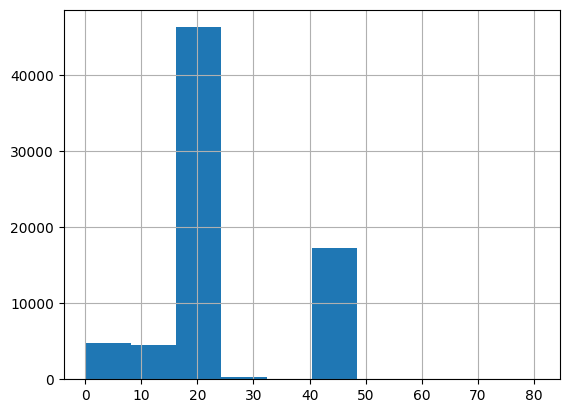

In [13]:
weather_df['visibility'].hist()

<Axes: >

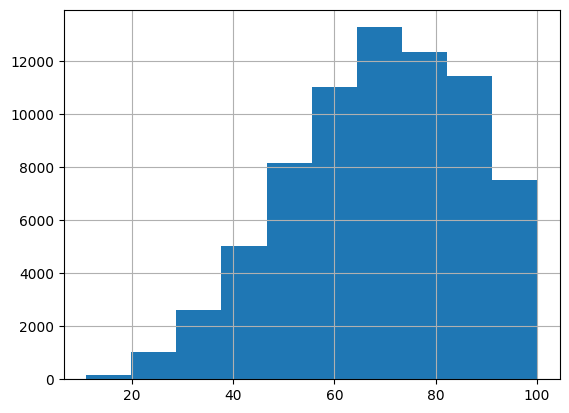

In [ ]:
weather_df['rel_humid'].hist()

# AQI data exploration

In [15]:
df1 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/0c325562-e742-4e8e-8c36-971f3c9e58cd/download/rsqa-indice-qualite-air-2022-2024.csv', '2022-2024.csv')
df2 = get_csv('https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/e43dc1d6-fbdd-49c3-a79f-83f63404c281/download/rsqa-indice-qualite-air-2019-2021.csv', '2019-2021.csv')
df3 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/93a3a88e-97ab-4ab1-813f-5419a1dd330d/download/rsqa-indice-qualite-air-2016-2018.csv", "2016-2018.csv")
df4 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/02cfaf0c-3b46-4dac-bf66-acd2ff47361a/download/rsqa-indice-qualite-air-2013-2015.csv", "2013-2015.csv")
df5 = get_csv("https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/6e59c6e9-749b-4237-9c45-5c627be2b7ad/download/rsqa-indice-qualite-air-2010-2012.csv", "2010-2012.csv")

2022-2024.csv not found locally. Downloading and reading from URL...
2019-2021.csv not found locally. Downloading and reading from URL...
2016-2018.csv not found locally. Downloading and reading from URL...
2013-2015.csv not found locally. Downloading and reading from URL...
2010-2012.csv not found locally. Downloading and reading from URL...


In [16]:
df = pd.concat([df1, df2, df3, df4, df5])
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['heure'].astype(str) + ':00:00',
                                format = '%Y-%m-%d %H:%M:%S',
                                errors = 'coerce')
df.drop(["heure", "polluant", "date"], axis=1, inplace=True)
df.sort_values("datetime", inplace=True)

df = filter_known_range(df)

assert df[df.isna().any(axis=1)].empty == True
df

,stationId,valeur,datetime
94688,80,14,2016-01-01 00:00:00
94689,80,2,2016-01-01 00:00:00
263314,66,2,2016-01-01 00:00:00
94690,80,5,2016-01-01 00:00:00
263312,66,1,2016-01-01 00:00:00
...,...,...,...
758344,28,3,2024-05-09 23:00:00
758626,66,6,2024-05-09 23:00:00
758372,99,0,2024-05-09 23:00:00
758345,28,10,2024-05-09 23:00:00


In [17]:
# the data contains measurements across various stations (spread over the MTL territory).
# We can take the maximum measurement for a given station for a given datetime (regardless of the pollutant).
# Note: we are assuming each pollutant contributes equally to the AQI level
# (Using the maximum pollutant value as a representative AQI is simplistic. Real AQI calculation may involve more complex computations where different pollutants have different weights or scale adjustments based on their health impact.)
group1_df = df.groupby(['stationId', 'datetime']).max("valeur")

# Manually verifying the maximum has been taken for a given station id on a given datetime
group1_df

valeur
stationId datetime                   
3         2016-01-01 00:00:00      13
          2016-01-01 01:00:00      15
          2016-01-01 02:00:00      16
          2016-01-01 03:00:00      16
          2016-01-01 04:00:00      17
...                               ...
103       2024-05-09 19:00:00      12
          2024-05-09 20:00:00      14
          2024-05-09 21:00:00      14
          2024-05-09 22:00:00      15
          2024-05-09 23:00:00      13

[790433 rows x 1 columns]

In [18]:
# Get the mean across all station maximums for each datetime
group2_df = group1_df.groupby("datetime").mean("valeur")
group2_df.reset_index(inplace=True)

## Feature engineering

In [19]:
merged = pd.merge(group2_df, weather_df, on="datetime", how="left")

merged['year'] = merged['datetime'].dt.year

merged['month'] = merged['datetime'].dt.month
merged['day'] = merged['datetime'].dt.day
merged['weekday'] = merged['datetime'].dt.weekday
merged['hour'] = merged['datetime'].dt.hour

# TODO: not clamping result in a lower loss but weirdly worse predictions. Perhaps the model doesn't generalize as good?
merged['valeur'] = merged['valeur'].clip(upper=100)
valeur_max = merged['valeur'].max()
merged['valeur'] = merged['valeur'] / valeur_max


merged


,datetime,valeur,temp,precip,rel_humid,weather,wind_chill,pressure,visibility,year,month,day,weekday,hour
0,2016-01-01 00:00:00,0.133636,-1.3,0.0,80.0,Mostly Cloudy,-7.0,100.92,24.1,2016,1,1,4,0
1,2016-01-01 01:00:00,0.142727,-1.2,0.0,79.0,Mostly Cloudy,-8.0,100.92,24.1,2016,1,1,4,1
2,2016-01-01 02:00:00,0.143636,-1.5,0.0,78.0,Mostly Cloudy,-7.0,100.91,24.1,2016,1,1,4,2
3,2016-01-01 03:00:00,0.143636,-1.7,0.0,78.0,Snow,-7.0,100.93,24.1,2016,1,1,4,3
4,2016-01-01 04:00:00,0.157273,-2.5,0.0,84.0,Snow,-8.0,100.88,9.7,2016,1,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73243,2024-05-09 19:00:00,0.133636,12.4,0.0,65.0,Mostly Cloudy,-6.0,100.67,24.1,2024,5,9,3,19
73244,2024-05-09 20:00:00,0.133636,10.9,0.0,71.0,Mostly Cloudy,-6.0,100.71,24.1,2024,5,9,3,20
73245,2024-05-09 21:00:00,0.121818,10.7,0.0,71.0,Mostly Cloudy,-6.0,100.71,24.1,2024,5,9,3,21
73246,2024-05-09 22:00:00,0.119091,9.9,0.0,77.0,Mainly Clear,-6.0,100.71,24.1,2024,5,9,3,22


In [20]:
(train_idxs, valid_idxs, test_idxs) = split_data(merged)

train_valid_df = pd.concat([
    merged.loc[train_idxs],
    merged.loc[valid_idxs],
])

train_valid_df

,datetime,valeur,temp,precip,rel_humid,weather,wind_chill,pressure,visibility,year,month,day,weekday,hour
0,2016-01-01 00:00:00,0.133636,-1.3,0.0,80.0,Mostly Cloudy,-7.0,100.92,24.1,2016,1,1,4,0
1,2016-01-01 01:00:00,0.142727,-1.2,0.0,79.0,Mostly Cloudy,-8.0,100.92,24.1,2016,1,1,4,1
2,2016-01-01 02:00:00,0.143636,-1.5,0.0,78.0,Mostly Cloudy,-7.0,100.91,24.1,2016,1,1,4,2
3,2016-01-01 03:00:00,0.143636,-1.7,0.0,78.0,Snow,-7.0,100.93,24.1,2016,1,1,4,3
4,2016-01-01 04:00:00,0.157273,-2.5,0.0,84.0,Snow,-8.0,100.88,9.7,2016,1,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64243,2023-04-30 19:00:00,0.200000,11.5,1.4,77.0,Cloudy,-22.0,99.42,24.1,2023,4,30,6,19
64244,2023-04-30 20:00:00,0.200000,10.8,0.2,81.0,Rain,-22.0,99.29,12.9,2023,4,30,6,20
64245,2023-04-30 21:00:00,0.207273,10.3,1.1,81.0,Mostly Cloudy,-22.0,99.12,24.1,2023,4,30,6,21
64246,2023-04-30 22:00:00,0.204545,11.0,0.0,73.0,Cloudy,-22.0,98.92,24.1,2023,4,30,6,22


# LSTM Arch


No idea what I did and it turned out to not be as good although I'm possibly not understanding how I can improve this

In [ ]:
import pandas as pd
import numpy as np

# Assuming `df` is your original DataFrame
n_steps = 24  # Number of time steps you look back

# This function creates sequences
def create_sequences(df, n_steps):
    features = ['valeur', 'temp', 'rel_humid', 'year', 'month', 'day', 'weekday', 'hour']
    X, y, times = [], [], []
    for i in range(n_steps, len(df)):
        # Create sliding windows
        times.append(df.iloc[i]['datetime'])  # Capture the datetime for each output sample

        without_date = df[features]
        X.append(without_date.iloc[i-n_steps:i].values)
        y.append(without_date.iloc[i]['valeur'])  # Assuming 'valeur' is the target to predict
    return np.array(X), np.array(y), np.array(times)

# Select relevant features

# Create sequences
X, y, times = create_sequences(merged, n_steps)

In [ ]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15  # Ensure these add up to 1

# Calculate indices
train_idx = int(len(X) * train_ratio)
val_idx = train_idx + int(len(X) * val_ratio)

X_train, X_val, X_test = X[:train_idx], X[train_idx:val_idx], X[val_idx:]
y_train, y_val, y_test = y[:train_idx], y[train_idx:val_idx], y[val_idx:]
times_train, times_val, times_test = times[:train_idx], times[train_idx:val_idx], times[val_idx:]

In [ ]:
from fastai.tabular.all import *
import torch
import torch.nn as nn

class LSTMModel(Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Forward propagate LSTM
        x, _ = self.lstm(x)
        # Decode the hidden state of the last time step
        x = self.fc(x[:, -1, :])
        return x.squeeze(-1)

In [ ]:
from torch.utils.data import TensorDataset

# Convert the training, validation, and test sets into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
# Assuming train_ds, val_ds, and test_ds have been created
bs = 2048  # batch size
shuffle_train = False  # Typically you do not shuffle time series data

dls = DataLoaders.from_dsets(train_ds, val_ds, bs=bs, shuffle=shuffle_train, device='cuda')

In [ ]:
input_dim = X_train.shape[2]  # Number of input features per timestep
hidden_dim = 50  # Number of features in the hidden state
output_dim = 1  # Predicting a single output
num_layers = 1  # Number of LSTM layers

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
learn = Learner(dls, model, loss_func=F.mse_loss, metrics=[mae])

# Train the model
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,mae,time
0,0.087085,0.036761,0.166471,00:04
1,0.042547,0.006553,0.059983,00:02
2,0.024306,0.004618,0.049804,00:02
3,0.015622,0.004143,0.047150,00:02
4,0.010921,0.003837,0.045018,00:03
5,0.008179,0.003598,0.043271,00:02
6,0.006509,0.003468,0.042275,00:02
7,0.005471,0.003405,0.041839,00:02
8,0.004826,0.003381,0.041655,00:02
9,0.004427,0.003377,0.041623,00:03


In [ ]:
test_dl = dls.test_dl(test_ds, with_labels=True, bs=64)
preds, targets = learn.get_preds(dl=test_dl)

mae(preds, targets)

TensorBase(0.0505)

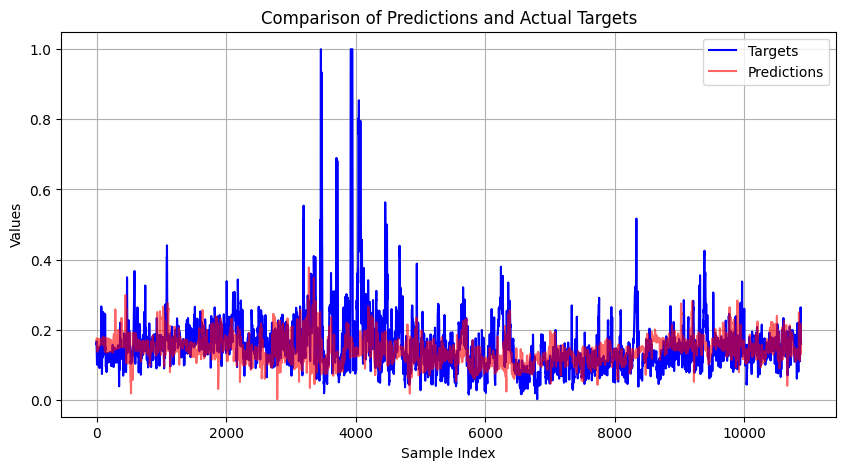

In [ ]:
# Converting tensors to numpy arrays for plotting
preds_array = preds.numpy()
targets_array = targets.numpy()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(targets_array, label='Targets', color='blue')
plt.plot(preds_array, label='Predictions', color='red', alpha=0.6)
plt.title('Comparison of Predictions and Actual Targets')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

# Simple NN

In [21]:
dls = mk_dls(train_valid_df)

dls.show_batch()

,datetime,weather,year,month,weekday,temp,precip,rel_humid,wind_chill,pressure,visibility,day,hour,valeur
0,2019-02-13 18:00:00,Snow,2019,2,2,-1.800000,1.764979e-10,87.000000,-8.0,99.580002,16.100000,13.0,18.0,0.208000
1,2020-05-20 17:00:00,Mostly Cloudy,2020,5,2,23.200001,1.764979e-10,23.000001,-6.0,102.209999,48.300000,20.0,17.0,0.239000
2,2018-07-01 15:00:00,Mostly Cloudy,2018,7,6,33.099999,1.764979e-10,49.999999,-14.0,100.959999,24.100000,1.0,15.0,0.298000
3,2017-03-22 23:00:00,Mostly Cloudy,2017,3,2,-9.200000,1.764979e-10,43.000000,-14.0,102.639999,24.100000,22.0,23.0,0.168182
4,2020-05-13 10:00:00,Clear,2020,5,2,8.700000,1.764979e-10,30.999998,-6.0,101.910004,48.300000,13.0,10.0,0.178182
5,2021-04-09 17:00:00,Mostly Cloudy,2021,4,4,23.399999,1.764979e-10,28.000000,-6.0,101.010002,48.300000,9.0,17.0,0.267273
6,2020-03-21 23:00:00,Mostly Cloudy,2020,3,5,-5.600000,1.764979e-10,48.000000,-12.0,103.290001,24.100000,21.0,23.0,0.179091
7,2021-08-06 03:00:00,Mostly Cloudy,2021,8,4,20.999999,1.764979e-10,78.000000,-5.0,101.370003,19.299999,6.0,3.0,0.451818
8,2017-10-19 18:00:00,Mostly Cloudy,2017,10,3,17.799999,1.764979e-10,61.000000,-7.0,100.620003,24.100000,19.0,18.0,0.255455
9,2016-12-17 03:00:00,Snow,2016,12,5,-15.100000,1.764979e-10,85.000000,-23.0,101.809998,4.800000,17.0,3.0,0.247273


I've noticed that reducing the number of activations on the last layer helps

In [ ]:
hidden=[250,100]

SuggestedLRs(valley=0.0003981071640737355, slide=0.009120108559727669)

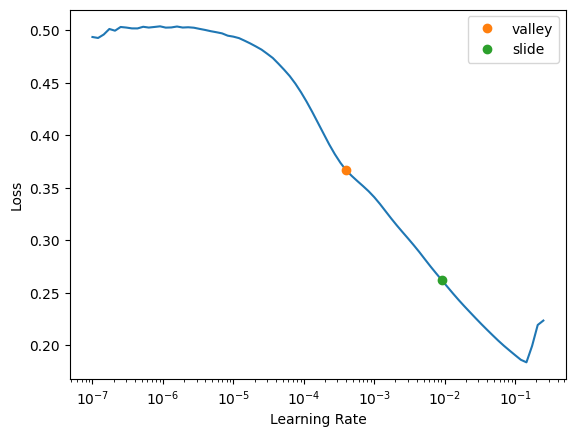

In [ ]:
tabular_learner(dls, metrics=mae, layers=hidden).lr_find(suggest_funcs=[valley, slide])

In [ ]:
learn = tabular_learner(dls, metrics=mae, layers=hidden, y_range=(0, 1))
learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,mae,time
0,0.128597,0.150258,0.383596,00:00
1,0.112167,0.108188,0.324000,00:00
2,0.077996,0.018020,0.096356,00:00
3,0.047599,0.007951,0.059853,00:00
4,0.028308,0.004225,0.051524,00:00
5,0.016849,0.002884,0.039663,00:00
6,0.010165,0.002639,0.036828,00:01
7,0.006211,0.002613,0.036618,00:01
8,0.003834,0.002554,0.036235,00:00
9,0.002404,0.002552,0.036228,00:00


In [22]:
# learn.export('model.pkl')
learn = load_learner('aqi-model.pkl')

In [23]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

preds, targets = learn.get_preds(dl=test_dl)

mae(preds, targets)

TensorBase(0.0471)

In [24]:
analysis_df = mk_analysis_df(df_test, preds.flatten(), valeur_max)

# plot_preds(analysis_df)
# plot_preds(analysis_df)

In [25]:
# exports
export_df = analysis_df
export_df.set_index('datetime', inplace=True)
# export_df = export_df.resample('D').mean()
# Resample to
export_df = export_df.resample('4H').mean()
export_df.reset_index(inplace=True)
export_df.rename(columns={'datetime': 'date'}, inplace=True)

mean_error = export_df['Error'].mean()

json_output = export_df.to_json(orient='records', indent=2)
json_dict = json.loads(json_output)

# Create a new dictionary with the "results" property
result_dict = {"mean_error": mean_error, "results": json_dict}

# Convert dictionary to JSON string with indentation
final_json_str = json.dumps(result_dict, indent=4)

# Write the JSON output to a file
with open('aqi.json', 'w') as file:
    file.write(final_json_str)

# Bagging

In [ ]:
def train(n_models, train_df, train_idxs, valid_idxs, test_df):
  total_length = len(train_idxs)
  subset_size = int(total_length * 0.8)  # Each model trains on 80% of data
  # Determine the maximum start index for training to ensure full subset_size can be used
  max_start_idx = total_length - subset_size
  predictions = []

  # This will train sequentially but it's fine since we're not going to create many models
  for n in range(1, n_models + 1):
    # Calculate start index for each model to ensure time series order is maintained
    start_idx = (n * max_start_idx) // n_models
    end_idx = start_idx + subset_size
    # Generate contiguous subset of train_idxs
    model_train_idxs = train_idxs[start_idx:end_idx]

    to = mk_dls(train_df)

    learn = tabular_learner(to, metrics=mae, layers=[500, 250], y_range=(0, 1))

    lrs = learn.lr_find()

    learn.fit_one_cycle(10, lrs.valley)
    test_dl = to.test_dl(test_df)
    preds, targets = learn.get_preds(dl=test_dl)
    predictions.append(preds)

  return (torch.stack(predictions).mean(dim=0), targets)

epoch,train_loss,valid_loss,mae,time
0,0.134040,0.159566,0.394311,00:01
1,0.118284,0.218395,0.457891,00:01
2,0.084665,0.031068,0.163430,00:02
3,0.051144,0.007810,0.076476,00:02
4,0.031191,0.004526,0.053067,00:02
5,0.019744,0.003572,0.042979,00:02
6,0.012996,0.003681,0.044781,00:01
7,0.008855,0.003734,0.043852,00:01
8,0.006334,0.003413,0.041039,00:01
9,0.004748,0.003688,0.044517,00:01


epoch,train_loss,valid_loss,mae,time
0,0.140414,0.107902,0.322486,00:01
1,0.126849,0.090963,0.294602,00:01
2,0.096944,0.033374,0.175433,00:01
3,0.061740,0.009308,0.086168,00:01
4,0.038059,0.003808,0.046524,00:01
5,0.024005,0.003542,0.043397,00:01
6,0.015589,0.003424,0.041436,00:01
7,0.010473,0.003753,0.044810,00:02
8,0.007303,0.003467,0.041423,00:01
9,0.005363,0.003443,0.041303,00:01


epoch,train_loss,valid_loss,mae,time
0,0.136585,0.185902,0.426722,00:01
1,0.121059,0.230575,0.476017,00:02
2,0.087035,0.018821,0.129057,00:02
3,0.052592,0.004501,0.052140,00:01
4,0.032077,0.004285,0.050438,00:01
5,0.020293,0.003706,0.042765,00:01
6,0.013307,0.003697,0.041838,00:01
7,0.009078,0.003992,0.044813,00:01
8,0.006449,0.003977,0.045506,00:01
9,0.004826,0.003730,0.043615,00:01


epoch,train_loss,valid_loss,mae,time
0,0.130229,0.129187,0.354106,00:01
1,0.116777,0.119724,0.340333,00:01
2,0.089606,0.060243,0.237632,00:01
3,0.057632,0.012368,0.101697,00:02
4,0.035689,0.005550,0.062324,00:02
5,0.022622,0.003764,0.045791,00:01
6,0.014799,0.004025,0.048034,00:01
7,0.010013,0.003620,0.043068,00:01
8,0.007069,0.003498,0.041879,00:01
9,0.005240,0.003535,0.042154,00:01


epoch,train_loss,valid_loss,mae,time
0,0.139917,0.112666,0.329747,00:01
1,0.123431,0.097216,0.306086,00:02
2,0.089983,0.027739,0.157693,00:03
3,0.055061,0.006350,0.067526,00:04
4,0.033673,0.005285,0.058817,00:06
5,0.021308,0.004142,0.045709,00:02
6,0.013928,0.004543,0.050970,00:01
7,0.009442,0.003653,0.042833,00:01
8,0.006681,0.003720,0.043584,00:01
9,0.004975,0.003740,0.043290,00:01


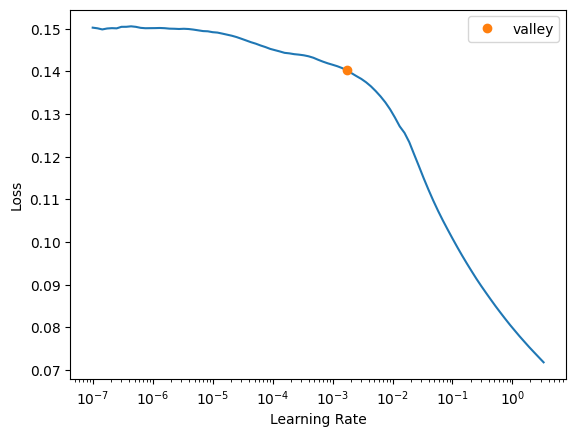

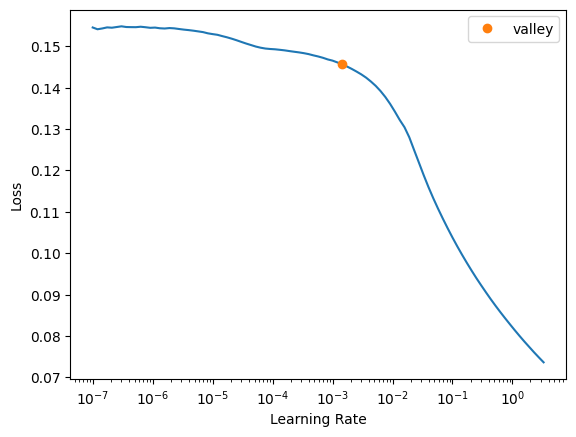

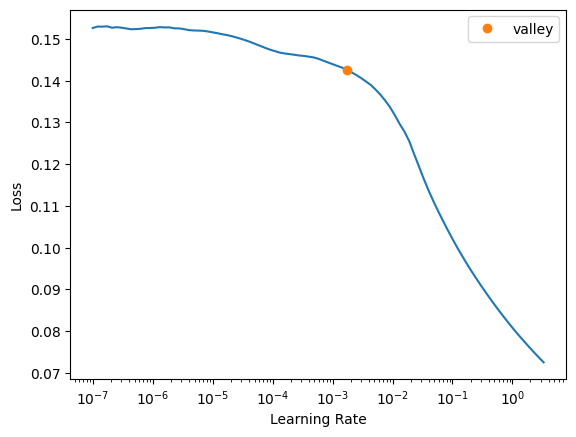

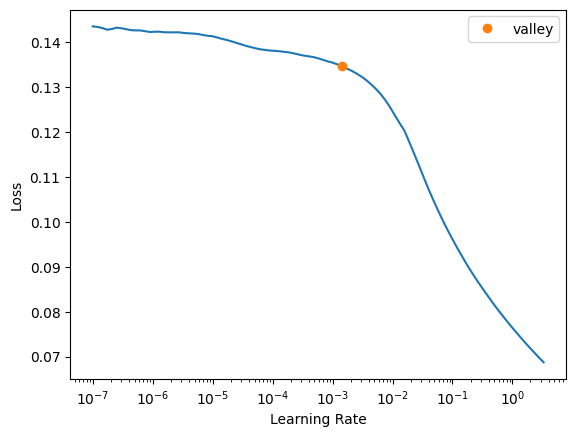

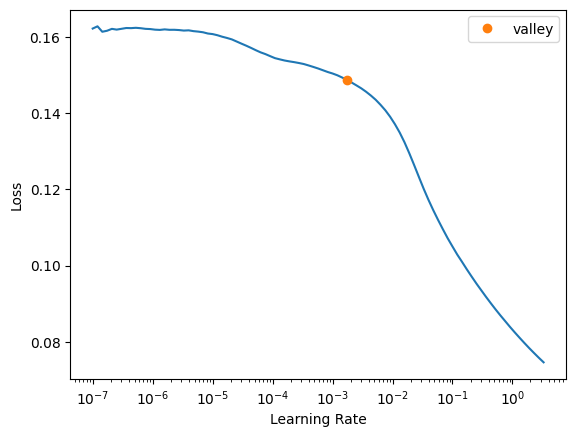

In [ ]:
(all_preds, targets) = train(5, merged, train_idxs, valid_idxs, merged.loc[test_idxs])

In [ ]:
mae(all_preds, targets)

TensorBase(0.0579)

In [ ]:
analysis_df = mk_analysis_df(merged.loc[test_idxs], all_preds, scaler)
plot_preds(analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 464), layout=Layout(widt…

# Ensemble

In [ ]:
def train(n_model, dls):
  all_preds = []
  for x in range(1, n_model + 1):
    learn = tabular_learner(dls, metrics=mae, layers=[500, 250], y_range=(0, 1))
    with learn.no_logging(), learn.no_mbar():
      learn.fit_one_cycle(10, learn.lr_find())
    df_test = merged.loc[test_idxs]
    test_dl = dls.test_dl(df_test)
    preds, targets = learn.get_preds(dl=test_dl)
    print(mae(preds, targets))

    all_preds.append(preds)
  return (torch.stack(all_preds).mean(dim=0), targets)


TensorBase(0.0610)


TensorBase(0.0621)


TensorBase(0.0470)


TensorBase(0.0555)


TensorBase(0.0606)


TensorBase(0.0547)

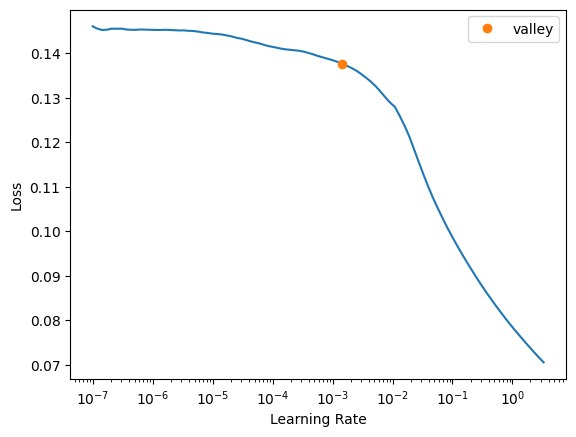

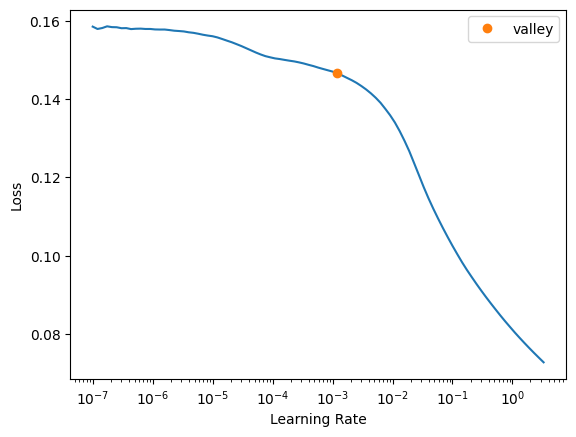

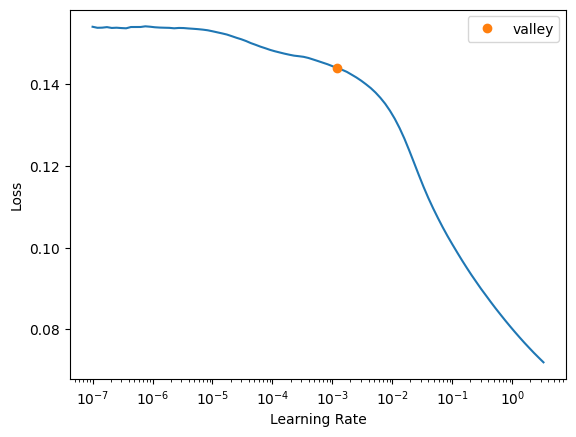

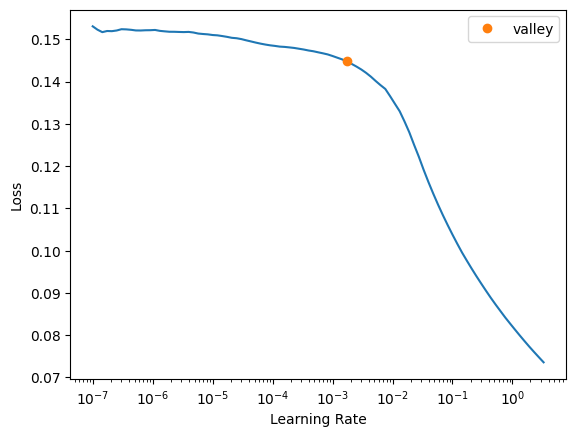

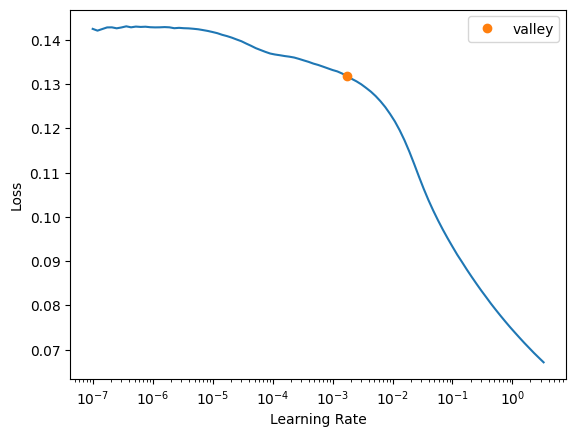

In [ ]:
(all_preds, targets) = train(5, mk_dls(merged))
mae(all_preds, targets)

In [ ]:
analysis_df = mk_analysis_df(merged.loc[test_idxs], all_preds.flatten(), scaler)

# plot_preds(analysis_df)
plot_preds(analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 464), layout=Layout(widt…

# Random forest impl

_RandomForest doesn't seem to offer much better results than using deep learning for this dataset._

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import torch

m = RandomForestRegressor(n_jobs=-1, n_estimators=250,
        max_samples=10_000, max_features=0.5,
        min_samples_leaf=5, oob_score=True).fit(dls.train.xs, dls.train.y)
preds = m.predict(dls.valid.xs)
preds_tensor = torch.tensor(preds)

mae(preds_tensor, torch.tensor(dls.valid.y.values))

TensorBase(0.0356)

In [ ]:
rf_df_test = merged.loc[test_idxs]
rf_test_dl = dls.test_dl(rf_df_test)

In [ ]:
rf_preds = torch.tensor(m.predict(rf_test_dl.xs))
mae(rf_preds, torch.tensor(rf_test_dl.y.values))

TensorBase(0.0447)

In [ ]:
rf_analysis_df = mk_analysis_df(rf_df_test, rf_preds, scaler)
rf_analysis_df

,datetime,Actual,Predicted
61368,2023-01-01 00:00:00,21.818182,20.499594
61369,2023-01-01 01:00:00,15.909091,20.477940
61370,2023-01-01 02:00:00,12.363636,20.122352
61371,2023-01-01 03:00:00,10.909091,20.145337
61372,2023-01-01 04:00:00,11.363636,19.016294
...,...,...,...
72523,2024-04-09 19:00:00,22.818182,21.940070
72524,2024-04-09 20:00:00,21.272727,20.905654
72525,2024-04-09 21:00:00,20.727273,20.377859
72526,2024-04-09 22:00:00,19.727273,19.903525


In [ ]:
plot_preds(rf_analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 464), layout=Layout(widt…